### Analysis of the scraped data

#### Fossil fuel and renewables data cleaning, aggregating and plotting (all in thousands of megawatthours)

 - Fossil and renewable energy data both show net generation per month, by energy source
 - See Spider files for exactly what is included under each heading

In [18]:
import numpy as np
from scipy import stats
import pandas as pd

from pathlib import Path
import statsmodels.api as sm
from pylab import rcParams
import re

import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import plotly
plotly.tools.set_credentials_file(username='scollier95', api_key='fPWI7fnBxIFigL28FW7m')
#plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import colorlover as cl

###### Read in data from the scraped csv's

In [2]:
old_renewable_data_path = Path("renewable_energy_old/RenewableEnergyOld.csv")
renewable_generation = pd.read_csv(old_renewable_data_path, index_col = 5)

old_fossil_data_path = Path("fossil_energy_old/FossilEnergyOld.csv")
fossil_fuel_generation = pd.read_csv(old_fossil_data_path, index_col = 4)

In [3]:
new_renewable_data_path = Path("renewable_energy_new/RenewableEnergyNew.csv")
renewable_generation = renewable_generation.append(pd.read_csv(new_renewable_data_path, index_col = 5))

new_fossil_data_path = Path("fossil_energy_new/FossilEnergyNew.csv")
fossil_fuel_generation = fossil_fuel_generation.append(pd.read_csv(new_fossil_data_path, index_col = 4))

In [4]:
fossil_fuel_generation.drop_duplicates(inplace = True)

In [ ]:
print(fossil_fuel_generation.shape)
print(fossil_fuel_generation.head(1))
print(fossil_fuel_generation.tail(1))
print(renewable_generation.shape)
print(renewable_generation.head(1))
print(renewable_generation.tail(1))

In [ ]:
print(fossil_fuel_generation.dtypes)
print(renewable_generation.dtypes)

In [6]:
# Join the tables to make a plot featuring all of the main energy sources
energy_gen = pd.merge(fossil_fuel_generation,renewable_generation, how = 'inner', left_index = True, right_index = True)

In [7]:
# Following Plot.ly example for filled area plot, altering xticks and adding chart title and axis labels
x = energy_gen.index.tolist()
linewidth = 1.5
brbg = cl.scales['10']['div']['BrBG']

coal = dict(x=x, y=energy_gen['coal'].tolist(), hoverinfo='x+y', mode='lines', \
            line=dict(width=linewidth, color = brbg[1]), stackgroup='one', name='Coal')

petroleum = dict(x=x, y=(energy_gen['petro_coke']+energy_gen['petro_liquids']).tolist(), \
                 hoverinfo='x+y', mode='lines', line=dict(width=linewidth, color = brbg[3]), name='Petroleum', stackgroup='one')

gas = dict(x=x, y=(energy_gen['natural_gas']+energy_gen['other_gas']).tolist(), \
           hoverinfo='x+y', mode='lines', line=dict(width=linewidth, color = brbg[0]), name = 'Gas', stackgroup='one')

nuclear = dict(x=x, y=energy_gen['nuclear'].tolist(), hoverinfo='x+y', mode='lines',\
            line=dict(width=linewidth, color = brbg[2]), name = 'Nuclear', stackgroup='one')

wind = dict(x=x, y=energy_gen['wind'].tolist(), hoverinfo='x+y', mode='lines',\
            line=dict(width=linewidth, color = brbg[-4]), stackgroup='one', name='Wind')

solar = dict(x=x, y=(energy_gen['solarpv_utility']+energy_gen['solarpv_small']+energy_gen['solar_thermal']).tolist(), \
             hoverinfo='x+y', mode='lines',line=dict(width=linewidth, color = brbg[-3]), stackgroup='one', name='Solar')

biomass = dict(x=x, y=(energy_gen['bmsw']+energy_gen['landfill_gas']+energy_gen['other_waste']+energy_gen['wood']).tolist(), \
               hoverinfo='x+y', mode='lines',line=dict(width=linewidth, color = brbg[-2]), stackgroup='one', name='Biomass')

geothermal = dict(x=x, y=energy_gen['geothermal'].tolist(), hoverinfo='x+y', mode='lines',\
            line=dict(width=linewidth, color = brbg[-1]), stackgroup='one', name='Geothermal')

hydro = dict(x=x, y=energy_gen['hydro'].tolist(), hoverinfo='x+y', mode='lines',\
            line=dict(width=linewidth, color = brbg[-5]), stackgroup='one', name='Hydro')

data=[gas, coal, nuclear, petroleum, hydro, wind, solar, biomass, geothermal]

labels = ['January 2015', 'January 2016','January 2017','January 2018','January 2019']
tickvals = ['January 2015', 'January 2016','January 2017','January 2018','January 2019']

layout = dict(title = dict(text = 'Monthly energy generation', font = dict(family='calibri', size = 32)),
              xaxis=go.layout.XAxis(ticktext=labels, tickvals=tickvals, title='Month', titlefont = dict(family='calibri', size = 24), tickangle=20, tickfont = dict(family='calibri', size = 18)),
              yaxis = dict(title = '000\'s of megawatt hours', titlefont = dict(family='calibri', size = 24), tickfont= dict(family='calibri', size = 18), exponentformat='e'),
              shapes = [{ 'type':'line', 'x0':'20 January 2017', 'y0':0, 'x1':'20 January 2017', 'y1':420000, \
                            'line':dict(color = '#ff0000', width = 2, dash = 'dashdot')}],
             legend = dict(yanchor = 'middle', y = 0.5, font = dict(family='calibri', size = 20)))
# orientation = 'h', x = 0, y = 1.07,
fig=dict(data=data, layout=layout)
plotly.plotly.iplot(fig, fileopt = 'overwrite', filename = 'filled-area-us-electricity-generation')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~scollier95/0 or inside your plot.ly account where it is named 'filled-area-us-electricity-generation'


C:\Users\Sam\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



 - Looks as if there is an annual pattern in the above data - lets split it before and after Trump was inaugurated, and see if there has been a change in the monthly averages
 - Do this separately for renewables and fossil fuels to make dealing with the gropued tables easier

In [8]:
# For the total energy frame, split it either side of Trump's inauguration,
# get the months as a column on their own, make them categorical so that they 
# retain order

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', \
          'September', 'October', 'November', 'December']

energy_gen['month'] = energy_gen.index.map(lambda x: re.sub('[\d\s]','',x))
energy_gen['month']= pd.Categorical(energy_gen['month'], categories = months, ordered = True)

pre_trump = energy_gen.loc['January 2015':'January 2017']
post_trump = energy_gen.loc['February 2017':]

In [9]:
# Group the two resulting frames to average over the time period for each month, then add
# columns showing the total renewable/fossil energy/nuclear (i.e. summed over the sources, have to delve
# into the MultiIndex object of the grouped data frame)

group_pre_t = pre_trump.groupby('month').agg(['mean'])
group_post_t = post_trump.groupby('month').agg(['mean'])

# Exclude nuclear from the column names, as it is not really renewable or fossil
# Make a vector to index with that selects just the renewable/fossil columns to sum

r_col_logical = [True if i in set(renewable_generation.columns) else False for i in group_pre_t.columns.levels[0]]
group_pre_t['total_renewable'] = group_pre_t.loc[:,r_col_logical].sum(axis = 1)
group_post_t['total_renewable'] = group_post_t.loc[:,r_col_logical].sum(axis = 1)

no_nuclear = group_pre_t.columns.levels[0][group_pre_t.columns.levels[0] != 'nuclear']
f_col_logical = [True if i in set(fossil_fuel_generation.columns) else False for i in no_nuclear]
group_pre_t['total_ff'] = group_pre_t.loc[:,no_nuclear].loc[:,f_col_logical].sum(axis = 1)
group_post_t['total_ff'] = group_post_t.loc[:,no_nuclear].loc[:,f_col_logical].sum(axis = 1)

Now plot the nuclear, total renewable and total fossil fuel monthly average for the two portions of time and see if we can see a big difference

In [10]:

dark2 = cl.scales['6']['qual']['Dark2']
pre_t_ff = go.Scatter(x=months, y = list(group_pre_t['total_ff']), name = 'Pre Trump fossil fuels', \
                      line = dict(color = dark2[0],width = 4))

post_t_ff = go.Scatter(x=months, y = list(group_post_t['total_ff']), name = 'Post Trump fossil fuels', \
                       line = dict(color = dark2[1],width = 4))

data2 = [pre_t_ff, post_t_ff]

layout2 = dict(title = dict(text = 'Pre and post inauguration average fossil fuel generation', font = dict(family='calibri', size = 32)), 
               xaxis = dict(title = 'Month', titlefont = dict(family='calibri', size = 24), tickangle = 35, tickfont = dict(family='calibri', size = 18)),
               yaxis = dict(title = '000\'s of megawatt hours', titlefont = dict(family='calibri', size = 24), tickfont= dict(family='calibri', size = 18), exponentformat='e'), 
               legend = dict(orientation = 'h', yanchor = 'bottom', xanchor = 'center', x = 0.5, y = 1, font = dict(family='calibri', size = 20)))

fig2 = dict(data=data2, layout=layout2)
# plotly.offline.iplot(fig2)
plotly.plotly.iplot(fig2, fileopt = 'overwrite', filename = 'pre-and-post-trump-ff-gen')

C:\Users\Sam\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [11]:
dark2 = cl.scales['6']['qual']['Dark2']

pre_t_r = go.Scatter(x=months, y = list(group_pre_t['total_renewable']), name = 'Pre Trump<br>renewables', \
                       line = dict(color = dark2[2],width = 4))

post_t_r = go.Scatter(x=months, y = list(group_post_t['total_renewable']), name = 'Post Trump<br>renewables', \
                       line = dict(color = dark2[3],width = 4))

pre_t_n = go.Scatter(x=months, y = list(group_pre_t['nuclear']['mean']), name = 'Pre Trump<br>nuclear', \
                       line = dict(color = dark2[4],width = 4))

post_t_n = go.Scatter(x=months, y = list(group_post_t['nuclear']['mean']), name = 'Post Trump<br>nuclear', \
                       line = dict(color = dark2[5],width = 4))
data3 = [post_t_n, pre_t_n, post_t_r, pre_t_r]

layout3 = dict(title = dict(text = 'Pre and post inauguration <br> average renewable and nuclear generation', font = dict(family='calibri', size = 30)),
               xaxis = dict(title = 'Month', titlefont = dict(family='calibri', size = 24), tickangle = 35, tickfont = dict(family='calibri', size = 18)),
               yaxis = dict(title = '000\'s of megawatt hours', titlefont = dict(family='calibri', size = 24), tickfont= dict(family='calibri', size = 18), exponentformat='e'),
               legend = dict(yanchor = 'middle', y = 0.5, font = dict(family='calibri', size = 20)))

fig3= dict(data=data3, layout=layout3)
# plotly.offline.iplot(fig3)
plotly.plotly.iplot(fig3, fileopt = 'overwrite', filename = 'pre-and-post-trump-renewable-and-nuclear-gen')

C:\Users\Sam\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



 - Doesn't seem to be much difference! In fact, looks like post-Trump there has been an average decrease in fossil fuel generation, and an average increase in renewable generation.
 - Use statistical tests to see if this difference is significant, need to check they are applicable before using them

In [12]:
renewable_generation['total'] = renewable_generation.sum(axis = 1)
ren_gen_pre_t = renewable_generation.loc['January 2015':'January 2017']
ren_gen_post_t = renewable_generation.loc['February 2017':]

In [13]:
fossil_fuel_generation['total'] = fossil_fuel_generation.loc[:,['coal', 'natural_gas', 'other_gas', 'petro_coke', 'petro_liquids']].sum(axis = 1)
fos_gen_pre_t = fossil_fuel_generation.loc['January 2015':'January 2017']
fos_gen_post_t = fossil_fuel_generation.loc['February 2017':]

In [14]:
renewable_generation

,bmsw,geothermal,hydro,landfill_gas,other_waste,solar_thermal,solarpv_small,solarpv_utility,wind,wood,total
period,,,,,,,,,,,
January 2015,582,1362,24138,885,258,63,746,1092,15162,3717,48005
February 2015,503,1260,22286,792,230,161,816,1322,14922,3372,45664
March 2015,543,1394,24281,914,255,286,1134,1786,15308,3457,49358
April 2015,571,1272,22471,915,243,372,1264,2008,17867,3246,50229
May 2015,609,1390,20125,951,238,345,1394,2160,17151,3338,47701
June 2015,607,1302,20414,926,251,380,1408,2178,13421,3496,44383
July 2015,661,1357,21014,1035,293,380,1487,2247,13675,3806,45955
August 2015,651,1344,19122,982,288,392,1468,2295,13080,3788,43410
September 2015,607,1203,16094,931,268,309,1330,1908,13972,3450,40072


               total
count      49.000000
mean   220246.469388
std     34752.397561
min    172031.000000
25%    193717.000000
50%    213917.000000
75%    242389.000000
max    293795.000000
median 213917.0


Text(0.5, 1.0, 'Distribution of monthly fossil fuel generation')

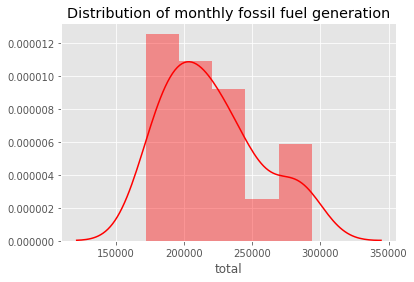

In [50]:
# Make histogram to visually inspect normality - assuming populations are the whole
# sets of renewable and fossil fuel generation data
print(fossil_fuel_generation[['total']].describe())
print('median ' + str(fossil_fuel_generation['total'].median()))
sns.distplot(fossil_fuel_generation['total'],color = 'r').set_title("Distribution of monthly fossil fuel generation")

              total
count     49.000000
mean   55134.428571
std     8012.308318
min    40072.000000
25%    48884.000000
50%    54899.000000
75%    59998.000000
max    70845.000000
median 54899.0


Text(0.5, 1.0, 'Distribution of monthly renewable generation')

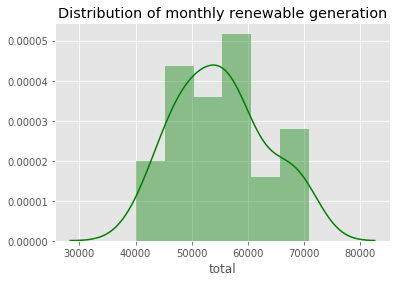

In [51]:
print(renewable_generation[['total']].describe())
print('median ' + str(renewable_generation['total'].median()))
sns.distplot(renewable_generation['total'],color = 'g').set_title("Distribution of monthly renewable generation")

In [43]:
# Do a Shapiro - Wilk test, which is supposed to be suitable for relatively smaller data sets
# Assumes a null hypothesis that data is normally distributed, low p-value means reject
stat1, p1 = stats.shapiro(fossil_fuel_generation['total'])
print(p1)

stat2, p2 = stats.shapiro(renewable_generation['total'])
print(p2)

0.00812461320310831
0.19853518903255463


In [ ]:
# Two sample t-test comparing means of fossil fuel generation time series before and after T-Day
stats.ttest_ind(np.array(fos_gen_pre_t['total']), np.array(fos_gen_post_t['total']), equal_var = False)

 - p-value well above threshold, therefore **cannot reject the null hypothesis that the mean fossil fuel generation before and after Trump's inauguration is the same** 

In [ ]:
# Two sample t-test for renewable generation
stats.ttest_ind(np.array(ren_gen_pre_t['total']), np.array(ren_gen_post_t['total']), equal_var = False)

 - p-value well below threshold, therefore **reject the null hypothesis that the mean renewable generation is the same either side of the inauguration**
 - Was the renewable generation already on an upward trend before the inauguration? This requires further time series analysis

In [ ]:
# Make a copy of the renewable generation data frame, changing the index to a datetime to make a timeseries
ren_gen_datetime_index = renewable_generation.copy()
ren_gen_datetime_index.index = pd.to_datetime(ren_gen_datetime_index.index)

# Decompose the time series data into three components
rcParams['figure.figsize'] = 20, 10
decomposition = sm.tsa.seasonal_decompose(ren_gen_datetime_index['total'], model='additive')
fig = decomposition.plot()
plt.show()